In [1]:
import spreg
from spreg import OLS
from spreg import ML_Error, ML_Error_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import robust_scale
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate

In [2]:
db = libpysal.io.open('../raw_data/basic_model_gdf.dbf','r')
df = gpd.read_file('../raw_data/basic_model_gdf.shp')

In [3]:
df.columns

Index(['PLR_ID', 'culture', 'outdoor_fa', 'outdoor_le', 'mig_rate', 'ave_rent',
       'social_hou', 'public_hou', 'child_pov', 'vegpm20', 'Gymnasium', 'kita',
       'stations', 'geometry'],
      dtype='object')

In [4]:
columns = [
'culture', 'outdoor_fa', 'outdoor_le', 'mig_rate', 'ave_rent',
       'social_hou', 'public_hou', 'vegpm20', 'Gymnasium', 'kita',
       'stations'
]
#regimes = db.by_col("label")

In [5]:
y = np.array(db.by_col('child_pov')).T
x_names = columns
X = np.array([db.by_col(var) for var in x_names]).T

In [6]:
queen = libpysal.weights.Queen.from_dataframe(df)

In [7]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(df, 5000, geom_col='geometry', binary=False)

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [8]:
rook = libpysal.weights.Rook.from_dataframe(df)

In [9]:
mlerror = ML_Error(y,
                   X,
                   name_x=columns,
                   name_y='child poverty',
                   w=inv_dist,
                   name_ds='selected_ds',
                   name_w='inv_dist')

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [29]:
print(mlerror.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            : selected_ds
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          12
S.D. dependent var  :     16.6701                Degrees of Freedom    :         524
Pseudo R-squared    :      0.6474
Sigma-square ML     :      97.112                Log likelihood        :   -1986.887
S.E of regression   :       9.855                Akaike info criterion :    3997.773
                                                 Schwarz criterion     :    4049.183

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------------------------------------

In [11]:
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

east.to_crs(crs='EPSG:25833', inplace=True)

west.to_crs(crs='EPSG:25833', inplace=True)

west = west.dissolve()

east = east.dissolve()

eastwest = east.append(west)

eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

/var/folders/sx/4s_zvfwj1xddph7py3s74ych0000gn/T/ipykernel_82274/1633683294.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eastwest = east.append(west)


In [13]:
df_east = df.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

df = df.merge(df_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

<AxesSubplot:>

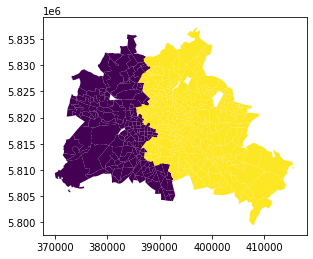

In [14]:
df.plot('east')

<AxesSubplot:>

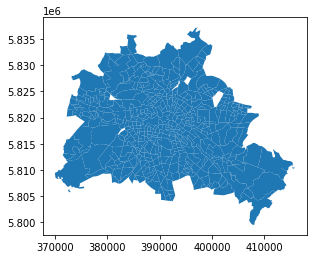

In [15]:
df.plot()

<AxesSubplot:>

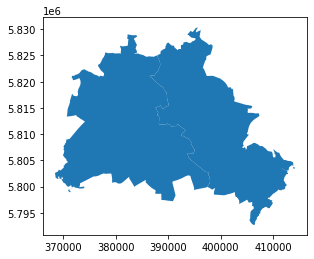

In [16]:
eastwest.plot()

In [25]:
mlerror_regimes = ML_Error_Regimes(y,
                   X,
                    regimes=df['east'],
                   name_x=columns,
                   name_y='child poverty',
                   w=inv_dist,
                   name_ds='selected_ds',
                   name_w='inv_dist')

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [26]:
print(mlerror_regimes.summary) # only significant difference in the coefficients is in green volume

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR - REGIMES (METHOD = full)
-----------------------------------------------------------------------------
Data set            : selected_ds
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          24
S.D. dependent var  :     16.6701                Degrees of Freedom    :         512
Pseudo R-squared    :      0.6953
Sigma-square ML     :      84.249                Log likelihood        :   -1948.581
S.E of regression   :       9.179                Akaike info criterion :    3945.162
                                                 Schwarz criterion     :    4047.981

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------